Machine learning models for energy demand forecasting

**Loading the dataset**

New England as used in the 2017 Global Energy Forecasting Competition (GEFCom2017) as available from Cameron Roach's repository at Github: https://github.com/camroach87/gefcom2017data

In [82]:
!pip install pyreadr

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [83]:
import requests
resp = requests.get("https://github.com/camroach87/gefcom2017data/raw/master/data/gefcom.rda", allow_redirects=True)
open('gefcom.rda', 'wb').write(resp.content)

6577272

In [84]:
import pyreadr
result = pyreadr.read_r('gefcom.rda')
df = result["gefcom"]

In [85]:
df.head()

,ts,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend
0,2003-03-01 00:00:00,CT,3386.0,25.0,19.0,2003-03-01,2003.0,Mar,1.0,Sat,60.0,True,NaN,False,0.0
1,2003-03-01 01:00:00,CT,3258.0,23.0,18.0,2003-03-01,2003.0,Mar,2.0,Sat,60.0,True,NaN,False,1.0
2,2003-03-01 02:00:00,CT,3189.0,22.0,18.0,2003-03-01,2003.0,Mar,3.0,Sat,60.0,True,NaN,False,2.0
3,2003-03-01 03:00:00,CT,3157.0,22.0,19.0,2003-03-01,2003.0,Mar,4.0,Sat,60.0,True,NaN,False,3.0
4,2003-03-01 04:00:00,CT,3166.0,23.0,19.0,2003-03-01,2003.0,Mar,5.0,Sat,60.0,True,NaN,False,4.0


In [86]:
df.zone.unique()

array(['CT', 'MASS', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'TOTAL',
       'VT', 'WCMASS'], dtype=object)

In [87]:
df.ts.dtypes

dtype('<M8[ns]')

/tmp/ipykernel_219838/2706281247.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


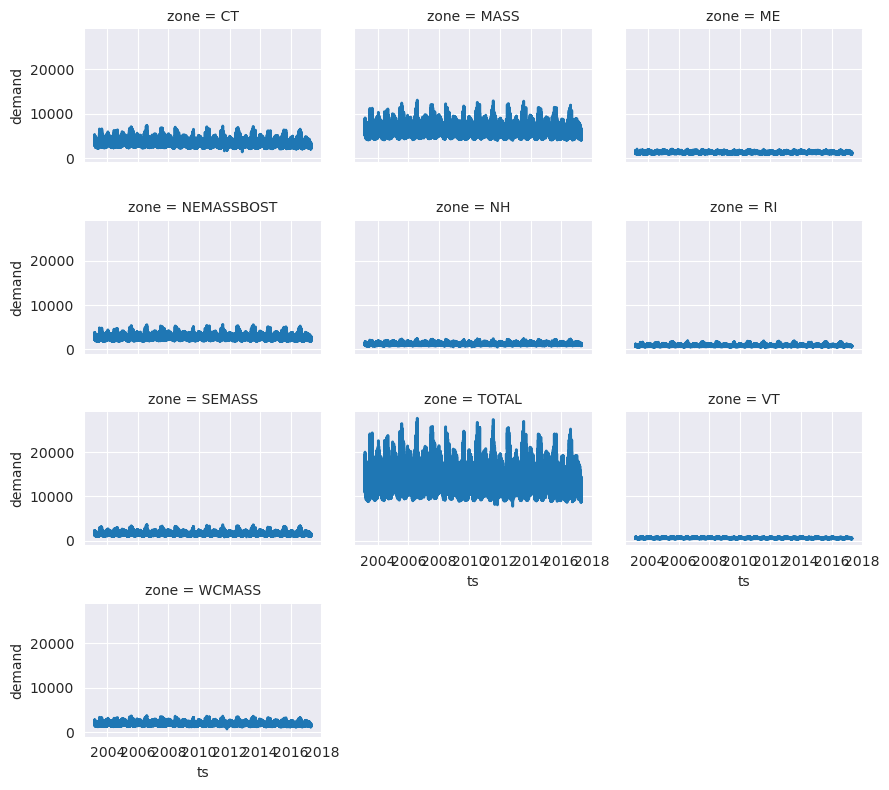

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.relplot(
    data=df,
    x="ts", y="demand", col="zone",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

<Axes: xlabel='ts', ylabel='demand'>

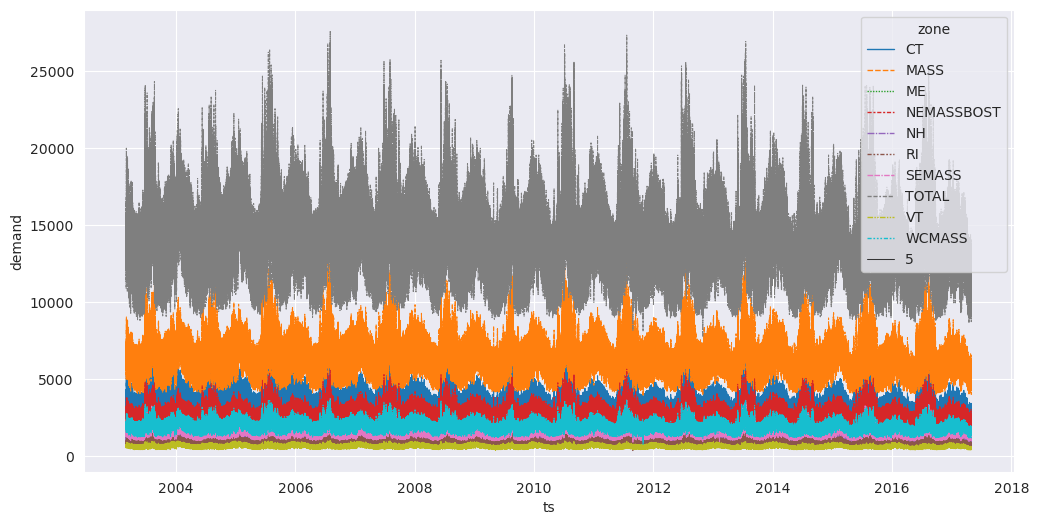

In [89]:
plt.subplots(figsize=[12, 6])
sns.lineplot(
    data=df, x="ts", y="demand", hue="zone", style="zone", size=5,
    estimator=None, color=".7", linewidth=1,
)

In [90]:
dataset = df[
             df["zone"].isin(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS',
                           'VT', 'WCMASS'])
             ]
# TOTAL and MASS are aggregated differently. We won't use these two "zones".

In [91]:
dataset.columns
# The Dry Bulb, Wet Bulb and Dew Point temperatures are important to determine the state of humid air

Index(['ts', 'zone', 'demand', 'drybulb', 'dewpnt', 'date', 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday', 'trend'],
      dtype='object')

<Axes: >

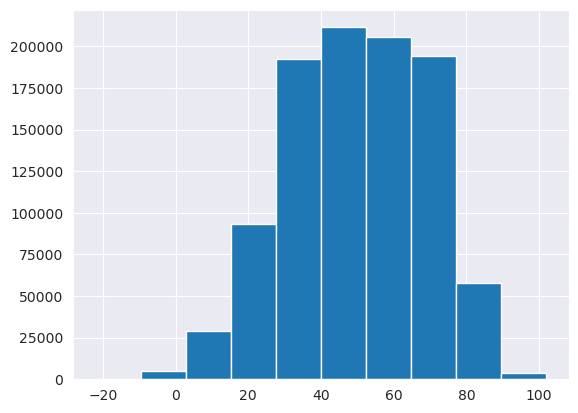

In [92]:
dataset.drybulb.hist()

<Axes: >

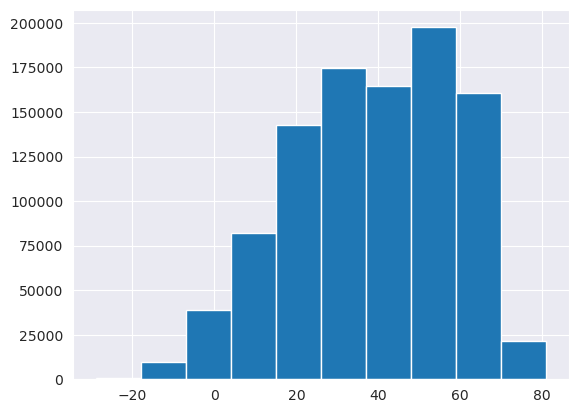

In [93]:
dataset.dewpnt.hist()

In [94]:
import pandas as pd

pivoted = dataset.pivot(index="ts", columns="zone", values="demand")

In [95]:
pivoted.columns

Index(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS'], dtype='object', name='zone')

In [96]:
# we could also add exogenous features like this:
pivoted2 = pivoted.merge(dataset[["ts", 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday']], on=["ts"], how="left").drop_duplicates()

In [97]:
T = len(pivoted.index)
split_t = pivoted.index[T//10 * 8]
split_index = pivoted.index < split_t

In [98]:
train, test = pivoted[split_index], pivoted[~split_index]

In [99]:
train.head()

zone,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,
2003-03-01 00:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0
2003-03-01 01:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0
2003-03-01 02:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0
2003-03-01 03:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0
2003-03-01 04:00:00,3166.0,1077.0,2426.0,1010.0,740.0,1419.0,574.0,1750.0


In [100]:
len(test) / (len(train) + len(test))

0.20000644272817325

## Modeling

In [101]:
!pip install skits

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [102]:
# we can use lagmat to transform a time series into a lagged wide dataset:
import numpy as np
from statsmodels.tsa.tsatools import lagmat

X = np.arange(1,7).reshape(-1,2)
# or: X = np.arange(2,7)
lagmat(X, maxlag=2, trim="forward", original='in')

array([[1., 2., 0., 0., 0., 0.],
       [3., 4., 1., 2., 0., 0.],
       [5., 6., 3., 4., 1., 2.]])

In [103]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# Fonction pour créer des caractéristiques autorégressives (remplace AutoregressiveTransformer)
def create_lag_features(df, column, lag_periods=[1, 2, 3, 7]):
    """Crée des caractéristiques décalées pour une colonne donnée."""
    df_copy = df.copy()
    for lag in lag_periods:
        df_copy[f'{column}_lag_{lag}'] = df_copy[column].shift(lag)
    return df_copy


# Fonction pour créer des caractéristiques saisonnières (remplace SeasonalTransformer)
def create_seasonal_features(df, column, period=24):
    """Crée des caractéristiques saisonnières pour une colonne donnée."""
    df_copy = df.copy()
    if df_copy.index.dtype != 'datetime64[ns]':
        print("Warning: Index should be datetime for proper seasonal features")

    # Ajouter des caractéristiques temporelles
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year

    # Créer des composantes saisonnières
    try:
        seasonal_result = seasonal_decompose(df_copy[column], period=period)
        df_copy[f'{column}_seasonal'] = seasonal_result.seasonal
        df_copy[f'{column}_trend'] = seasonal_result.trend
        df_copy[f'{column}_residual'] = seasonal_result.resid
    except:
        print("Could not perform seasonal decomposition, check data length and period")

    return df_copy


# Classe simple pour remplacer ForecasterPipeline
class TimeSeriesForecaster:
    def __init__(self, regressor=None, preprocessing=None):
        self.regressor = regressor if regressor else RandomForestRegressor()
        self.preprocessing = preprocessing if preprocessing else StandardScaler()
        self.pipeline = Pipeline([
            ('preprocessing', self.preprocessing),
            ('regressor', self.regressor)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

# Utilisation
# Exemple:

#
forecaster = TimeSeriesForecaster()
forecaster.fit(train.values, train.values)
y_pred = forecaster.predict(test.values)



In [104]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error([y_pred[0, 0]], [test.values[0, 0]])

# Calculer RMSE manuellement (équivalent à squared=False)
rmse = np.sqrt(mse)


In [105]:
# Calculer MSE puis appliquer la racine carrée
mse = mean_squared_error(y_pred, test.values)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")


RMSE: 28.95455344366348


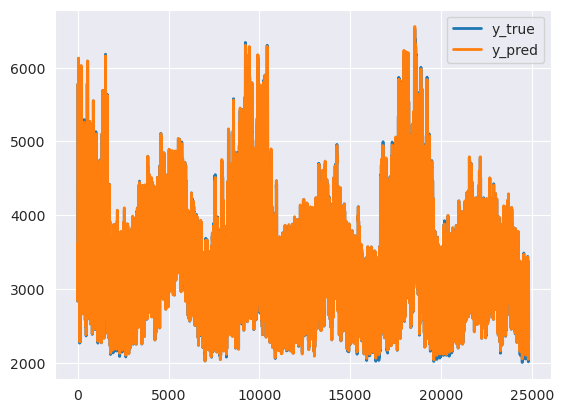

In [106]:
import matplotlib.pyplot as plt

plt.plot(test.values[:, 0], lw=2)
plt.plot(y_pred[:, 0], lw=2)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));

In [107]:
# Imports existants
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Ajout des imports manquants
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer  # Alternative à ReversibleImputer si nécessaire


# Création d'une classe ForecasterPipeline et autres composants nécessaires
# Si ces classes sont personnalisées, nous allons les implémenter de manière basique

class AutoregressiveTransformer:
    def __init__(self, num_lags=3):
        self.num_lags = num_lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Logique de base pour créer des caractéristiques autorégressives
        result = X.copy()
        for i in range(1, self.num_lags + 1):
            if len(X) > i:
                shifted = np.roll(X, i, axis=0)
                shifted[:i] = 0  # Pour éviter que les valeurs ne bouclent
                result = np.column_stack((result, shifted))
        return result

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


class ReversibleImputer:
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X.reshape(-1, 1) if X.ndim == 1 else X)
        return self

    def transform(self, X):
        X_shape = X.shape
        X_reshaped = X.reshape(-1, 1) if X.ndim == 1 else X
        return self.imputer.transform(X_reshaped).reshape(X_shape)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


class ForecasterPipeline:
    def __init__(self, steps):
        self.steps = steps
        self.named_steps = dict(steps)

    def fit(self, X, y=None):
        X_transformed = X
        for name, transformer in self.steps[:-1]:
            X_transformed = transformer.fit_transform(X_transformed, y)

        # Entraîner le dernier composant (regressor)
        name, regressor = self.steps[-1]
        regressor.fit(X_transformed, y)
        return self

    def predict(self, X, to_scale=False, refit=False):
        X_transformed = X
        for name, transformer in self.steps[:-1]:
            X_transformed = transformer.transform(X_transformed)

        # Prédire avec le regressor
        name, regressor = self.steps[-1]
        return regressor.predict(X_transformed)


# Ajout de numpy pour le support des opérations
import numpy as np

# Votre code original avec les imports nécessaires
pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', DecisionTreeRegressor())
])

# Reste de votre code
# pipeline.fit(train.values, train.values)
# y_pred = pipeline.predict(test.values, to_scale=True, refit=True)


pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [108]:
mean_squared_error(y_pred, test.values)

1757.4188539676397

In [109]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]])

5184.0

In [110]:
!pip install xgboost

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [111]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# other models to try out:
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=0), n_jobs=-1))
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [112]:
mean_squared_error(y_pred, test.values)

33.137457992870395

In [113]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]])

1.1941537857055664

In [114]:
!pip install catboost

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [115]:
from catboost import CatBoostRegressor
#from sklearn.impute import SimpleImputer

pipeline = ForecasterPipeline([
    #("impute", SimpleImputer(strategy="constant", fill_value=-9999)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=4)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    #('regressor', MultiOutputRegressor(CatBoostRegressor(random_state=0), n_jobs=-1))
    ('regressor', CatBoostRegressor(loss_function="MultiRMSE"))
])
pipeline.fit(train.values, train.values)

0:	learn: 1165.2816573	total: 41.3ms	remaining: 41.3s
1:	learn: 1133.7616942	total: 72.1ms	remaining: 36s
2:	learn: 1103.0157743	total: 106ms	remaining: 35.3s
3:	learn: 1073.1794026	total: 137ms	remaining: 34.1s
4:	learn: 1044.1762566	total: 168ms	remaining: 33.4s
5:	learn: 1016.0720654	total: 196ms	remaining: 32.4s
6:	learn: 988.6442707	total: 228ms	remaining: 32.4s
7:	learn: 962.0652157	total: 259ms	remaining: 32.1s
8:	learn: 936.1549183	total: 287ms	remaining: 31.6s
9:	learn: 911.0783647	total: 315ms	remaining: 31.1s
10:	learn: 886.9501500	total: 362ms	remaining: 32.6s
11:	learn: 863.3013952	total: 409ms	remaining: 33.7s
12:	learn: 840.2388063	total: 444ms	remaining: 33.7s
13:	learn: 818.2223681	total: 471ms	remaining: 33.2s
14:	learn: 796.8496521	total: 501ms	remaining: 32.9s
15:	learn: 775.9983968	total: 535ms	remaining: 32.9s
16:	learn: 755.7553542	total: 565ms	remaining: 32.7s
17:	learn: 735.9585332	total: 597ms	remaining: 32.5s
18:	learn: 716.9073797	total: 628ms	remaining: 32.

In [116]:
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)
mean_squared_error(y_pred, test.values)

743.9744921891605

In [117]:
MAXLAGS = 4

target_columns = ['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']
colnames = target_columns * MAXLAGS
lagged = pd.DataFrame(data=lagmat(pivoted, maxlag=MAXLAGS, trim="forward", original='ex'), columns=colnames, index=pivoted.index).join(train[[]])
lagged.head()

,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,...,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,,,,,,,,,,,,,,
2003-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 01:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 02:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 03:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,...,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 04:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0,3189.0,1053.0,...,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0


In [118]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor

split_index = lagged.index < split_t
training = lagged[split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = training[[c for c in training.columns if c not in target_columns]], training[[c for c in training.columns if c in target_columns]]

pipeline = make_pipeline(StandardScaler(), CatBoostRegressor(loss_function="MultiRMSE"))
pipeline.fit(X, y)
testing = lagged[~split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = testing[[c for c in testing.columns if c not in target_columns]], testing[[c for c in testing.columns if c in target_columns]]
forecast = pipeline.predict(X)
print(f"MSE all data: {mean_squared_error(y.values, forecast)}")
print(f"MSE first point: {mean_squared_error([y.values[0, 0]], [forecast[0, 0]])}")

0:	learn: 1167.6276143	total: 104ms	remaining: 1m 43s
1:	learn: 1137.7566574	total: 194ms	remaining: 1m 37s
2:	learn: 1108.8696510	total: 297ms	remaining: 1m 38s
3:	learn: 1080.7095940	total: 379ms	remaining: 1m 34s
4:	learn: 1053.6525844	total: 449ms	remaining: 1m 29s
5:	learn: 1027.3317924	total: 523ms	remaining: 1m 26s
6:	learn: 1001.8117388	total: 601ms	remaining: 1m 25s
7:	learn: 977.1431968	total: 670ms	remaining: 1m 23s
8:	learn: 953.5483974	total: 743ms	remaining: 1m 21s
9:	learn: 930.3806973	total: 809ms	remaining: 1m 20s
10:	learn: 907.8368348	total: 880ms	remaining: 1m 19s
11:	learn: 886.1815588	total: 954ms	remaining: 1m 18s
12:	learn: 865.1147136	total: 1.03s	remaining: 1m 17s
13:	learn: 844.6734539	total: 1.14s	remaining: 1m 20s
14:	learn: 824.8133956	total: 1.28s	remaining: 1m 23s
15:	learn: 805.8165671	total: 1.4s	remaining: 1m 26s
16:	learn: 786.9838657	total: 1.49s	remaining: 1m 26s
17:	learn: 768.9522987	total: 1.68s	remaining: 1m 31s
18:	learn: 751.7808768	total: 1.

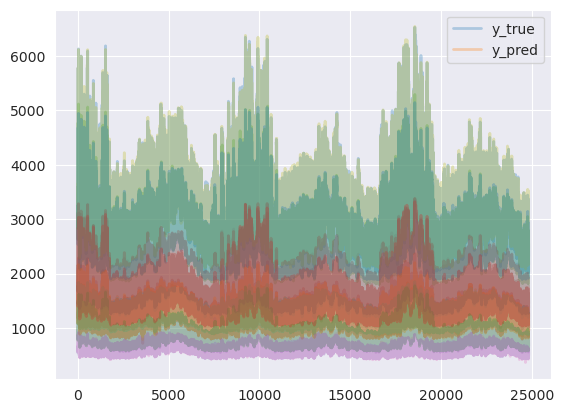

In [119]:
plt.plot(y.values, lw=2, alpha=0.3)
plt.plot(forecast, lw=2, alpha=0.3)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));